## Building the hydrophobic protrusion neighbourhood tables

This notebook contains all the code needed to build the hydrophobic protrusion neighbourhood tables used in further analysis later. The algorithm here is going throw every protrusion and finds features in the neighbourhood such as number of residues, number of residues that are protrusions, which amino acids do we have in the neighbourhood and so on.

### 1) Imports & global stuff

In [2]:
import os
import pandas as pd
import numpy as np
from biopandas.pdb import PandasPdb
from scipy.spatial import ConvexHull
import scipy.spatial.distance as scidist

import matplotlib.pyplot as plt
import matplotlib.lines as mlines
import matplotlib.transforms as mtransforms
import seaborn as sns

import tqdm

In [4]:
DISTANCE = 10
DENSITY = 22
HYDROPHOBICS = ['LEU', 'ILE', 'PHE', 'TYR', 'TRP', 'CYS', 'MET']
AMINO_ACIDS = ["TRP", "PHE", "GLY", "ALA", "VAL", "ILE", "LEU", "MET", "PRO", "TYR", "SER", "THR", "ASN", "GLN", "CYS", "LYS", "ARG", "HIS", "ASP", "GLU"]

# Some settings for pd and jupyter
pd.set_option('display.max_columns', 999)

### 2) Defining functions

In [8]:
def readIDs(filepath):
    """
    Read / parse a text file containing pdb ID's

    :param filepath: The path to the file to parse / read
    :return: The list of pdb ID's parsed
    """
    id_list = []
    with open(filepath) as f:
        for line in f:
            id_list.append(line.replace("\n", ""))

    return id_list

def extract_atom_table(path):
    """
    This function extracts the atom table of a given pdb, returns just rows of CA and CB.
    :param path: Path to the pdb file
    """
    return PandasPdb().read_pdb(path)


def trim_and_filter(pdb):
    """
    This function trims & filters the atomTable for some properties and returns the final atomTable for analysis.
    This function is mainly for peripheral proteins.
    """
    
    # Get atom table
    atomTable = pdb.df["ATOM"]
    
    # Subset only CA & CB atoms
    atomTable = atomTable.query("atom_name in ['CA', 'CB']")
    
    # Trim for multiple alternate locations
    atomTable = atomTable.query("alt_loc in ['A', '']")
    
    # return witch clean indicies
    return atomTable.reset_index()


def find_features(hydr_prot, idx_table, tables_filtered, protrusion_data):
    
    # Find atom table for the protrusion
    pdb_idx = idx_table.index(hydr_prot['pdb'])
    atomTable = tables_filtered[pdb_idx]

    # Compute distances
    m = atomTable[["x_coord", "y_coord", "z_coord"]].to_numpy()
    distvector = scidist.pdist(m)
    dist = scidist.squareform(distvector)

    # find the index of the (protrusion)atom in atom table to make use of distances
    atom_idx = atomTable.query("atom_number == " + str(hydr_prot['atom_number'])).index[0]

    # Identify all neighbours
    neighbours = [i for i,d in enumerate(dist[atom_idx]) if d < DISTANCE and d > 0]

    # Find unique residues
    neighbour_residues = atomTable.iloc[neighbours][["residue_number", "chain_id", "residue_name"]].drop_duplicates()

    # Remove this residue, as just wanting neighbours
    neighbour_residues = neighbour_residues[neighbour_residues["residue_number"] != hydr_prot['residue_number']]

    # Find neighbours in protrusion table 
    table = pd.DataFrame()
    tmp = protrusion_data.query("pdb == '" + hydr_prot["pdb"] + "'")
    for idx, row in neighbour_residues.iterrows():
        table = table.append(tmp[ (tmp["residue_number"] == row["residue_number"]) & (tmp["chain_id"] == row["chain_id"]) ])
    neighbours_that_are_protrusions = table["is_protrusion"].sum()
    neighbours_that_are_hydr_protrusions = table["is_hydrophobic_protrusion"].sum()

    # Count freq. of amino acids
    freq = neighbour_residues["residue_name"].value_counts()
    amino_acids_freq = [freq[acid] if acid in freq else 0 for acid in AMINO_ACIDS]

    # Building result
    result = dict(zip(AMINO_ACIDS, amino_acids_freq))
    # result["neighbours"] = len(neighbours)
    result["neighbourhood_num_of_residues"] = len(neighbour_residues)
    result["neighbourhood_residues_that_are_protrusions"] = neighbours_that_are_protrusions
    result["neighbourhood_residues_that_are_hydr_protrusions"] = neighbours_that_are_hydr_protrusions
    result["pdb"] = hydr_prot['pdb']
    result["residue_name"] = hydr_prot['residue_name']
    result["residue_number"] = hydr_prot['residue_number']
    result["chain_id"] = neighbour_residues["chain_id"]
    return [result]

### 3) Read the raw data & build the datasets / tables

In [9]:
# Read IDs
periph = readIDs("../periph_ids.csv")
tm = readIDs("../tm_ids.csv")

# Read files & make tables
periph_tables = []
tm_tables = []

for pdb in tqdm.tqdm(periph):
    periph_tables.append(extract_atom_table("../opm_data/periph/" + pdb + ".pdb"))
    
for pdb in tqdm.tqdm(tm):
    tm_tables.append(extract_atom_table("../opm_data/tm/" + pdb + ".pdb"))
    
# Trim & filter 
periph_tables_filtered = []
tm_tables_filtered = []

for pdb in tqdm.tqdm(periph_tables):
    periph_tables_filtered.append(trim_and_filter(pdb))
    
for pdb in tqdm.tqdm(tm_tables):
    tm_tables_filtered.append(trim_and_filter(pdb))

100%|██████████| 495/495 [00:07<00:00, 64.23it/s]


In [10]:
# Read protrusion tables from prev. step (see workspace 01)
periph_protrusion_data = pd.read_csv("../results_and_feature_datasets/periph_protrusion_data.csv", sep="\t", encoding="utf-8", index_col=0)
tm_protrusion_data = pd.read_csv("../results_and_feature_datasets/tm_protrusion_data.csv", sep="\t", encoding="utf-8", index_col=0)

In [11]:
# Build the datasets
tmp = []
tmp_df = periph_protrusion_data.query("is_hydrophobic_protrusion == 1")
for idx in tqdm.tqdm(range(len(tmp_df))):
    hydr_prot = tmp_df.iloc[idx]
    tmp = tmp + find_features(hydr_prot, periph, periph_tables_filtered, periph_protrusion_data)
periph_hydr_protrusion_neighbourhood_data = pd.DataFrame(tmp)

tmp = []
tmp_df = tm_protrusion_data.query("is_hydrophobic_protrusion == 1")
for idx in tqdm.tqdm(range(len(tmp_df))):
    hydr_prot = tmp_df.iloc[idx]
    tmp = tmp + find_features(hydr_prot, tm, tm_tables_filtered, tm_protrusion_data)
tm_hydr_protrusion_neighbourhood_data = pd.DataFrame(tmp)

100%|██████████| 568/568 [02:30<00:00,  3.76it/s]


In [12]:
# Save datasets
periph_hydr_protrusion_neighbourhood_data.to_csv("../periph_hydr_protrusion_neighbourhood_data.csv", sep="\t", encoding="utf-8")
tm_hydr_protrusion_neighbourhood_data.to_csv("../tm_hydr_protrusion_neighbourhood_data.csv", sep="\t", encoding="utf-8")

### 4) Analysis & plotting

In [3]:
periph_hydr_protrusion_neighbourhood_data = pd.read_csv("../results_and_feature_datasets/analysing_protrusion_neighbourhood_data/distance_10/periph_hydr_protrusion_neighbourhood_data.csv", sep="\t", encoding="utf-8", index_col=0)
tm_hydr_protrusion_neighbourhood_data = pd.read_csv("../results_and_feature_datasets/analysing_protrusion_neighbourhood_data/distance_10/tm_hydr_protrusion_neighbourhood_data.csv", sep="\t", encoding="utf-8", index_col=0)

In [4]:
# reassign, just for simpler reference in local code
d1 = periph_hydr_protrusion_neighbourhood_data
d2 = tm_hydr_protrusion_neighbourhood_data

In [5]:
d1_aminAcid = d1.iloc[:,0:20]
d2_aminAcid = d2.iloc[:,0:20]

In [6]:
# Melt everything to one table for better plotting
d1_aminAcid_melted = pd.melt(d1_aminAcid)
d1_aminAcid_melted["dataset"] = "periph"
d2_aminAcid_melted = pd.melt(d2_aminAcid)
d2_aminAcid_melted["dataset"] = "tm"
d_aminAcid_melted = d1_aminAcid_melted.append(d2_aminAcid_melted)

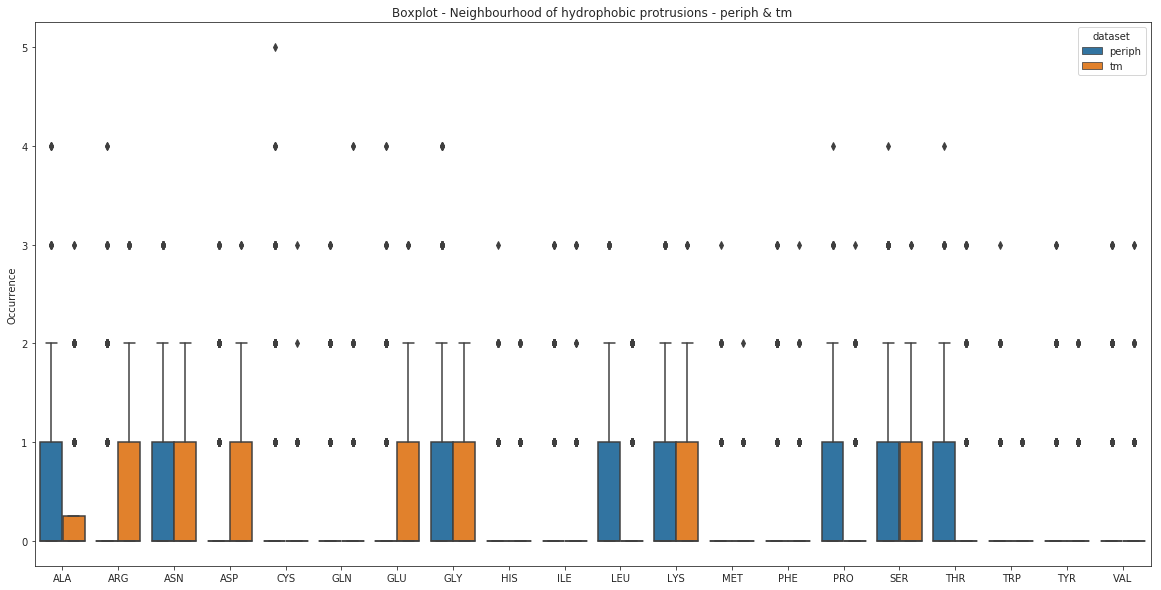

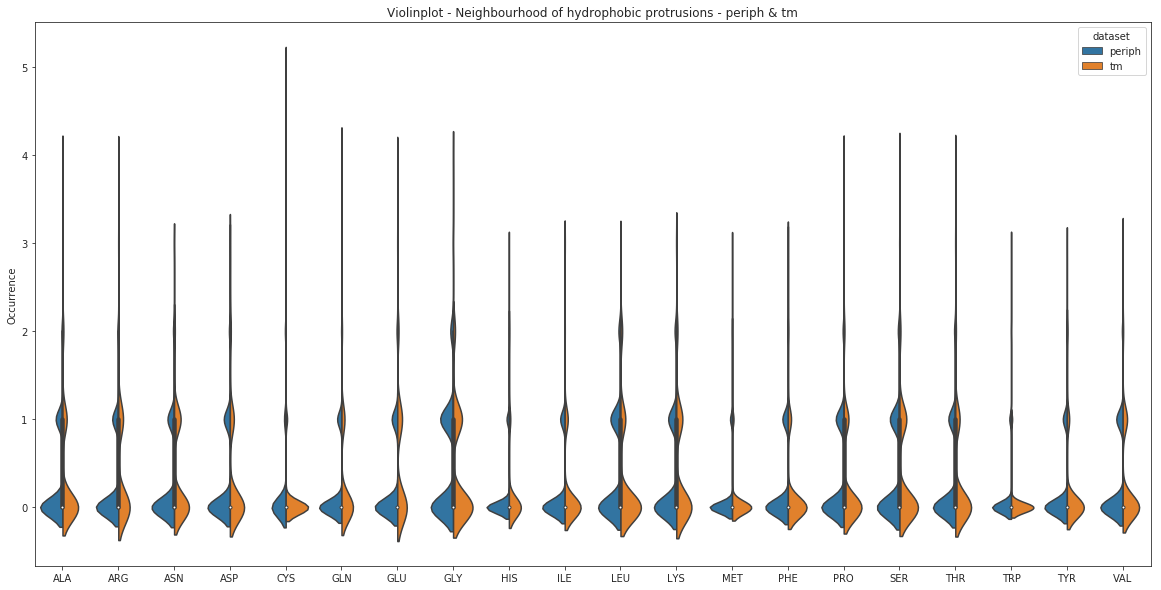

In [27]:
#plt.rcParams.update({'font.size': 12})
#flierprops = dict(marker='o', markerfacecolor='black', markersize=1, linestyle='none')
#
#d1[AMINO_ACIDS].plot(kind="box", flierprops=flierprops)
#axes = plt.gca()
#
#plt.title("Boxplot - Neighbourhood of hydrophobic protrusions - periph")
#plt.xlabel("Amino Acids")
#plt.ylabel("Occurrence")
#plt.savefig("../neighbarhood_of_hydrophobic_protrusions_periph.png", dpi=1200)
#
## =============================================================================
#
#d2[AMINO_ACIDS].plot(kind="box", flierprops=flierprops)
#axes = plt.gca()
#
#plt.title("Boxplot - Neighbourhood of hydrophobic protrusions - tm")
#plt.xlabel("Amino Acids")
#plt.ylabel("Occurrence")
#plt.savefig("../neighbarhood_of_hydrophobic_protrusions_tm.png", dpi=1200)

plt.figure(figsize=(20,10))
sns.set_style("ticks")
sns.boxplot(x="variable", y="value", hue="dataset", data=d_aminAcid_melted)
plt.title("Boxplot - Neighbourhood of hydrophobic protrusions - periph & tm")
plt.xlabel("")
plt.ylabel("Occurrence")
plt.savefig("../neighbarhood_of_hydrophobic_protrusions_boxplot.png", dpi=300)

# =============================================================================

plt.figure(figsize=(20,10))
sns.violinplot(x="variable", y="value", hue="dataset", data=d_aminAcid_melted, split=True)
plt.title("Violinplot - Neighbourhood of hydrophobic protrusions - periph & tm")
plt.xlabel("")
plt.ylabel("Occurrence")
plt.savefig("../neighbarhood_of_hydrophobic_protrusions_violinplot_split.png", dpi=300)


<br>
(!) Having a look on the mean, maybe there are some potential to normalize. Results below ..
<br>

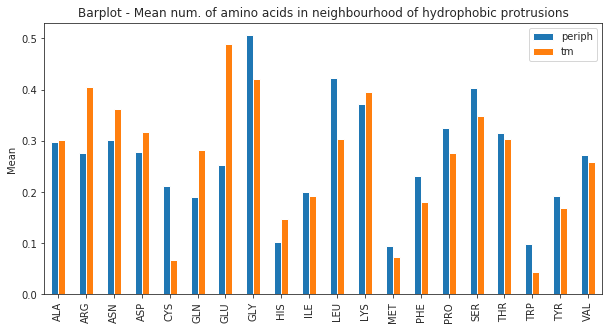

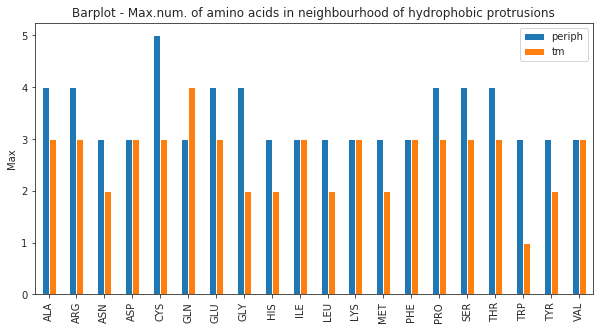

In [28]:
d_mean = pd.DataFrame()
d_mean["periph"] = d1_aminAcid.mean()
d_mean["tm"] = d2_aminAcid.mean()

plt.figure(figsize=(10,5))
d_mean.plot(kind="bar", ax=plt.gca())
plt.title("Barplot - Mean num. of amino acids in neighbourhood of hydrophobic protrusions")
plt.ylabel("Mean")
plt.savefig("../neighbarhood_of_hydrophobic_protrusions_meanNumOfAminAcids.png", dpi=300)

# =============================================================================

d_max = pd.DataFrame()
d_max["periph"] = d1_aminAcid.max()
d_max["tm"] = d2_aminAcid.max()

plt.figure(figsize=(10,5))
d_max.plot(kind="bar", ax=plt.gca())
plt.title("Barplot - Max.num. of amino acids in neighbourhood of hydrophobic protrusions")
plt.ylabel("Max")
plt.show()

# =============================================================================
# NB! Min.num of amino acids is always 0. Below code make not sense to present

#d_min = pd.DataFrame()
#d_min["periph"] = d1_aminAcid.min()
#d_min["tm"] = d2_aminAcid.min()
#
#d_min.plot(kind="bar")
#plt.title("Barplot - Min.num. of amino acids in neighbourhood of hydrophobic protrusions")
#plt.ylabel("Max")
#plt.show()

In [29]:
print "mean num of residues - periph:\t", d1["neighbourhood_num_of_residues"].mean()
print "mean num of residues - tm:\t", d2["neighbourhood_num_of_residues"].mean()

mean num of residues - periph:	5.339572192513369
mean num of residues - tm:	5.334507042253521


In [30]:
# Normalizing columns
d1_aminAcid_norm = (d1_aminAcid - d1_aminAcid.mean()) / (d1_aminAcid.max() - d1_aminAcid.min())
d2_aminAcid_norm = (d2_aminAcid - d2_aminAcid.mean()) / (d2_aminAcid.max() - d2_aminAcid.min())

d1_aminAcid_norm = d1_aminAcid_norm.fillna(0)
d2_aminAcid_norm = d2_aminAcid_norm.fillna(0);

In [31]:
# Melt everything to one table for better plotting
d1_aminAcid_norm_melted = pd.melt(d1_aminAcid_norm)
d1_aminAcid_norm_melted["dataset"] = "periph"
d2_aminAcid_norm_melted = pd.melt(d2_aminAcid_norm)
d2_aminAcid_norm_melted["dataset"] = "tm"
d_aminAcid_norm_melted = d1_aminAcid_norm_melted.append(d2_aminAcid_norm_melted)

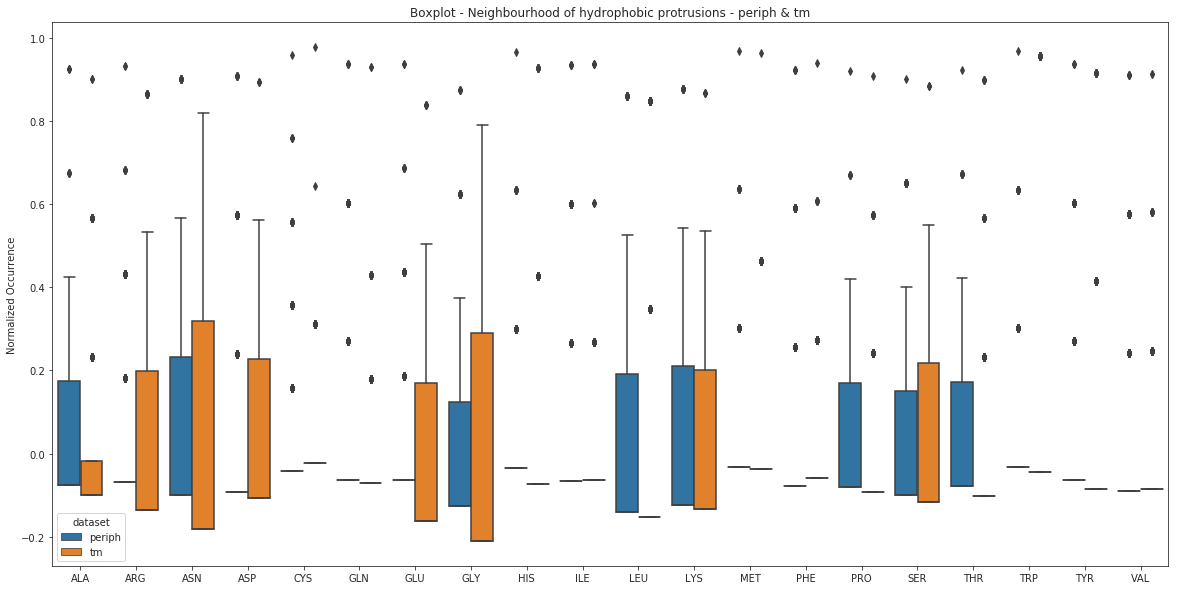

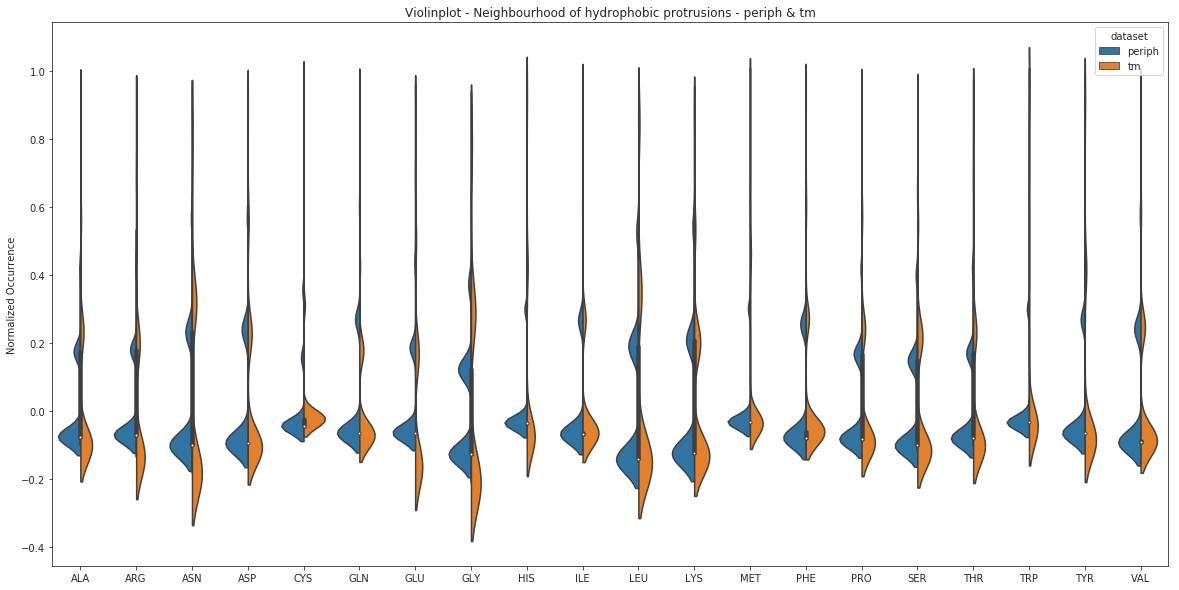

In [32]:
plt.figure(figsize=(20,10))
sns.set_style("ticks")
sns.boxplot(x="variable", y="value", hue="dataset", data=d_aminAcid_norm_melted)
plt.title("Boxplot - Neighbourhood of hydrophobic protrusions - periph & tm")
plt.xlabel("")
plt.ylabel("Normalized Occurrence")
plt.savefig("../neighbarhood_of_hydrophobic_protrusions_boxplot_normalized.png", dpi=300)

# =================================================================================================

#plt.figure(figsize=(20,10))
#sns.violinplot(x="variable", y="value", hue="dataset", data=d_aminAcid_norm_melted)
#plt.title("Violinplot - Neighbourhood of hydrophobic protrusions - periph & tm")
#plt.xlabel("")
#plt.ylabel("Normalized Occurrence")
#plt.savefig("../neighbarhood_of_hydrophobic_protrusions_normalized_violinplot.png", dpi=300)

# =================================================================================================

plt.figure(figsize=(20,10))
sns.violinplot(x="variable", y="value", hue="dataset", data=d_aminAcid_norm_melted, split=True)
plt.title("Violinplot - Neighbourhood of hydrophobic protrusions - periph & tm")
plt.xlabel("")
plt.ylabel("Normalized Occurrence")
plt.savefig("../neighbarhood_of_hydrophobic_protrusions_violinplot_split_normalized.png", dpi=300)

In [33]:
# Merge datasets with target identity 
d1_aminAcid["dataset"] = "periph"
d2_aminAcid["dataset"] = "tm"
d_aminAcid = d1_aminAcid.append(d2_aminAcid)

In [83]:
# Alternative dataset for pca
#d1_f = d1.iloc[:,0:24]
#d1_f["dataset"] = "periph"
#d2_f = d2.iloc[:,0:24]
#d2_f["dataset"] = "tm"
#d_aminAcid = d1_f.append(d2_f, sort=False)

In [ ]:
d_aminAcid

In [34]:
# Seperating features from target and perform scaling by sklearn
from sklearn.preprocessing import StandardScaler
#features = d_aminAcid.keys()[0:24]
features = d_aminAcid.keys()[0:20]
x = d_aminAcid.loc[:,features]
x = StandardScaler().fit_transform(x)

In [35]:
# Perform PCA
from sklearn.decomposition import PCA
pca = PCA(n_components=3)
principal_components = pca.fit_transform(x)

# Merge features and target again
d_aminAcid_pc = pd.DataFrame(data = principal_components, columns = ["pc1", "pc2", "pc3"])
d_aminAcid_pc["dataset"] = d_aminAcid["dataset"].tolist()

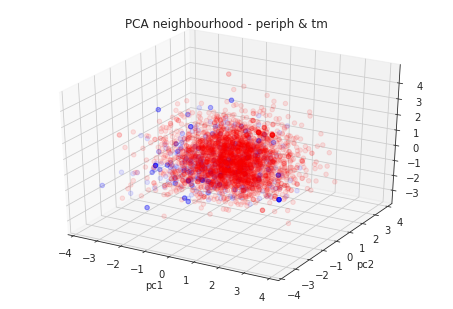

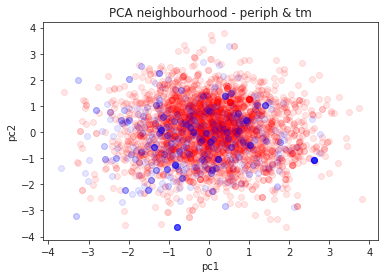

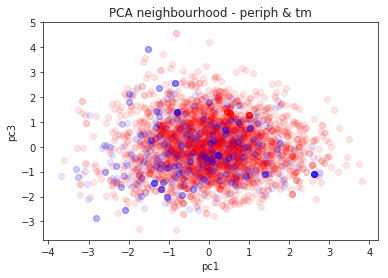

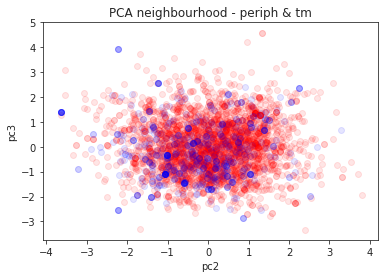

In [36]:
# Simple ploting
fig = plt.figure()
from mpl_toolkits.mplot3d import Axes3D
ax = Axes3D(fig)
ax.scatter(d_aminAcid_pc.query("dataset == 'periph'")["pc1"], d_aminAcid_pc.query("dataset == 'periph'")["pc2"], d_aminAcid_pc.query("dataset == 'periph'")["pc3"], c = "red", alpha = 0.1)
ax.scatter(d_aminAcid_pc.query("dataset == 'tm'")["pc1"], d_aminAcid_pc.query("dataset == 'tm'")["pc2"], d_aminAcid_pc.query("dataset == 'tm'")["pc3"], c = "blue", alpha = 0.1)
plt.title("PCA neighbourhood - periph & tm")
plt.xlabel("pc1")
plt.ylabel("pc2")
plt.show()

# =================================================================================================

plt.scatter(d_aminAcid_pc.query("dataset == 'periph'")["pc1"], d_aminAcid_pc.query("dataset == 'periph'")["pc2"], c = "red", alpha = 0.1)
plt.scatter(d_aminAcid_pc.query("dataset == 'tm'")["pc1"], d_aminAcid_pc.query("dataset == 'tm'")["pc2"], c = "blue", alpha = 0.1)
plt.title("PCA neighbourhood - periph & tm")
plt.xlabel("pc1")
plt.ylabel("pc2")
plt.show()

# =================================================================================================

plt.scatter(d_aminAcid_pc.query("dataset == 'periph'")["pc1"], d_aminAcid_pc.query("dataset == 'periph'")["pc3"], c = "red", alpha = 0.1)
plt.scatter(d_aminAcid_pc.query("dataset == 'tm'")["pc1"], d_aminAcid_pc.query("dataset == 'tm'")["pc3"], c = "blue", alpha = 0.1)
plt.title("PCA neighbourhood - periph & tm")
plt.xlabel("pc1")
plt.ylabel("pc3")
plt.show()

# =================================================================================================

plt.scatter(d_aminAcid_pc.query("dataset == 'periph'")["pc2"], d_aminAcid_pc.query("dataset == 'periph'")["pc3"], c = "red", alpha = 0.1)
plt.scatter(d_aminAcid_pc.query("dataset == 'tm'")["pc2"], d_aminAcid_pc.query("dataset == 'tm'")["pc3"], c = "blue", alpha = 0.1)
plt.title("PCA neighbourhood - periph & tm")
plt.xlabel("pc2")
plt.ylabel("pc3")
plt.show()


In [ ]:
d_aminAcid_pc

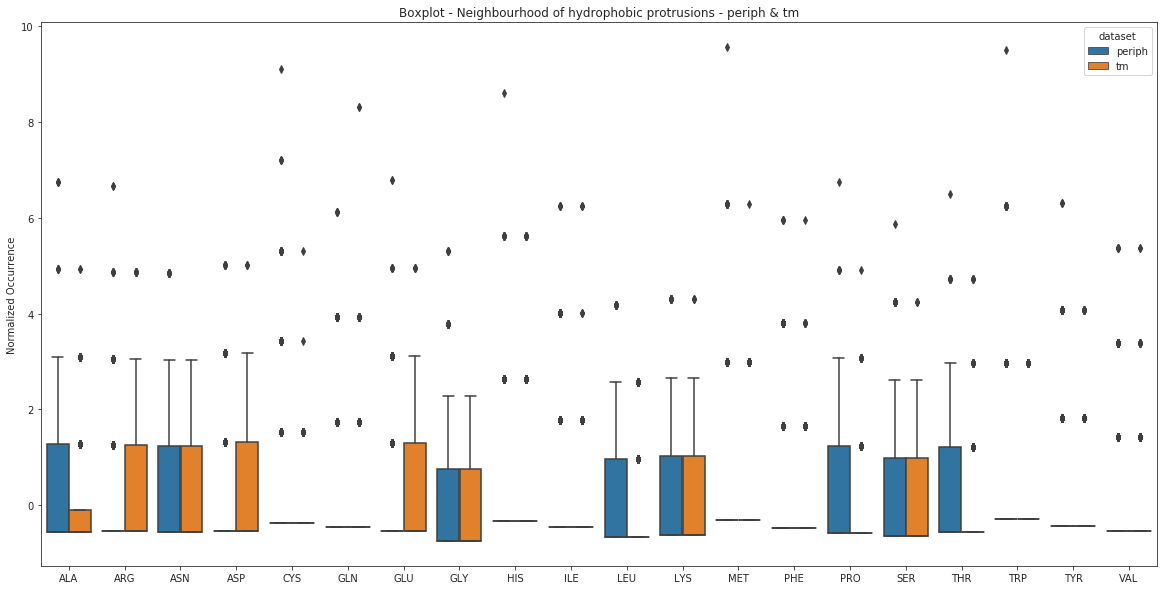

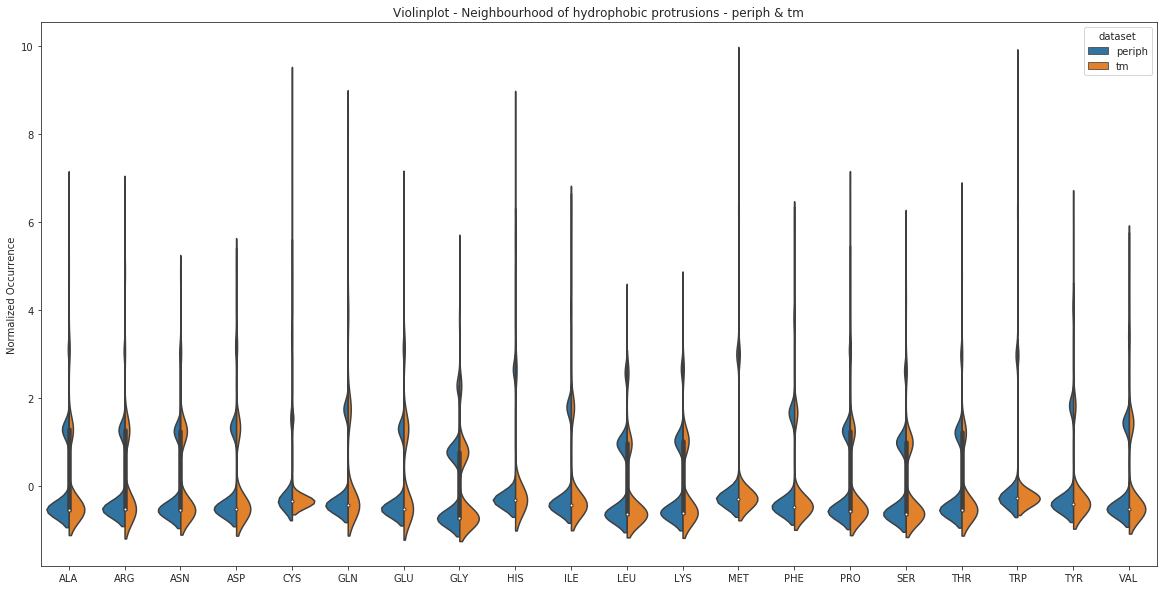

In [37]:
# Merge features and target again after scaling
d_aminAcid_norm = pd.DataFrame(x)
d_aminAcid_norm.columns = features
d_aminAcid_norm["dataset"] = d_aminAcid["dataset"].tolist()
d_aminAcid_norm_melted = d_aminAcid_norm.melt(id_vars=["dataset"])

# Plot stuff -- just to compare the normalization method
plt.figure(figsize=(20,10))
sns.set_style("ticks")
sns.boxplot(x="variable", y="value", hue="dataset", data=d_aminAcid_norm_melted)
plt.title("Boxplot - Neighbourhood of hydrophobic protrusions - periph & tm")
plt.xlabel("")
plt.ylabel("Normalized Occurrence")
#plt.show()
plt.savefig("../neighbarhood_of_hydrophobic_protrusions_boxplot_normalized.png", dpi=300)

# =================================================================================================

plt.figure(figsize=(20,10))
sns.violinplot(x="variable", y="value", hue="dataset", data=d_aminAcid_norm_melted, split=True)
plt.title("Violinplot - Neighbourhood of hydrophobic protrusions - periph & tm")
plt.xlabel("")
plt.ylabel("Normalized Occurrence")
#plt.show()
plt.savefig("../neighbarhood_of_hydrophobic_protrusions_violinplot_split_normalized.png", dpi=300)

In [52]:
len(d_aminAcid_melted)

74760

In [51]:
len(d_aminAcid_melted.query("variable == 'ALA'"))

3560

In [109]:
print len(d1)
print len(d2)

2992
568


In [55]:
print len(d_aminAcid_melted.query("variable == 'ALA' & dataset == 'periph' & value > 0"))
print len(d_aminAcid_melted.query("variable == 'ALA' & dataset == 'tm' & value > 0"))

1136
229


In [57]:
print "1136/2992", str(1136.0/2992.0), "%"
print "229/568", str(229.0/568.0), "%"

1136/2992 0.379679144385 %
229/568 0.403169014085 %


In [13]:
d2.query("neighbourhood_residues_that_are_hydr_protrusions > 0")

ALA  ARG  ASN  ASP  CYS  GLN  GLU  GLY  HIS  ILE  LEU  LYS  MET  PHE  \
16     1    2    0    1    0    1    1    0    0    0    1    0    0    1   
17     1    2    0    1    0    1    2    0    0    0    1    0    0    0   
44     0    1    1    2    0    0    0    2    0    0    0    0    1    0   
45     0    1    0    2    0    0    0    4    0    1    0    0    0    0   
58     1    0    0    0    3    0    0    2    0    0    0    0    1    1   
59     1    0    0    1    4    0    1    1    0    0    0    0    0    0   
82     0    0    0    1    0    0    0    0    0    1    0    0    0    1   
83     0    0    0    1    0    1    0    1    0    1    1    0    0    0   
87     0    0    0    2    1    0    1    1    1    0    0    0    0    1   
89     0    2    0    0    0    2    0    0    0    0    1    0    0    0   
90     0    2    0    0    0    1    0    0    0    0    2    1    0    0   
96     0    3    0    1    0    0    1    1    0    0    1    0    0    0   
97     0    3    0    1    0    0    0    2    0    0    2    0    0    0   
98     0    0    0    1    0    2    1    0    0    0    0    1    1    0   
99     1    1    0    2    0    2    1    0    0    0    0    1    1    0   
105    0    0    0    2    1    0    2    1    1    0    0    0    0    1   
139    0    0    0    0    0    0    0    0    2    0    1    3    0    0   
140    0    0    1    0    0    0    1    0    2    1    0    2    0    0   
141    0    0    0    0    0    0    0    0    2    0    1    3    0    0   
142    0    0    1    0    0    0    1    0    2    1    0    2    0    0   
147    0    0    0    1    0    1    0    1    0    1    1    0    0    1   
148    0    0    0    0    0    1    0    1    0    2    1    0    0    0   
236    5    0    2    0    0    0    0    3    1    0    2    0    0    0   
237    4    0    1    0    0    0    0    1    1    1    0    0    1    0   
239    5    0    2    0    0    0    0    3    1    0    2    0    0    0   
240    4    0    1    0    0    0    0    1    1    1    0    0    1    0   
252    0    0    0    1    0    2    2    0    0    1    0    1    0    0   
253    0    0    0    1    0    2    3    0    0    1    1    1    0    0   
254    0    1    0    0    1    2    1    0    0    0    1    1    0    0   
255    0    1    0    0    0    2    1    1    0    0    2    1    0    1   
..   ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...   
374    0    1    0    0    0    0    0    0    0    1    2    0    0    0   
375    0    1    0    0    1    0    1    0    0    0    3    0    0    0   
376    0    1    0    0    0    0    0    0    0    1    2    0    0    0   
377    0    1    0    0    1    0    1    0    0    0    3    0    0    0   
378    0    1    0    0    0    0    0    0    0    1    2    0    0    0   
379    0    1    0    0    1    0    1    0    0    0    3    0    0    0   
380    0    1    0    0    0    0    0    0    0    1    2    0    0    0   
381    0    1    0    0    1    0    1    0    0    0    3    0    0    0   
382    0    1    0    0    0    0    0    0    0    1    2    0    0    0   
399    0    1    1    0    0    0    0    0    0    0    0    0    0    1   
400    0    1    0    0    0    0    0    1    0    1    0    0    0    0   
422    1    1    2    0    0    1    0    1    0    0    1    1    0    0   
423    1    0    2    0    0    1    0    1    0    0    2    0    0    0   
459    0    0    0    2    1    0    1    1    0    0    0    0    0    1   
477    0    1    0    0    0    1    1    1    0    0    1    0    0    1   
478    0    0    0    0    0    1    1    0    0    0    1    0    0    1   
497    1    0    1    0    0    0    1    0    0    1    0    1    0    0   
498    0    0    1    0    0    0    0    0    0    0    0    0    0    1   
523    0    0    1    0    0    0    0    0    0    0    1    0    0    0   
524    0    1    1    0    0    0    0    1    0    0    1    0    0    0   
5

In [7]:
d1

ALA  ARG  ASN  ASP  CYS  GLN  GLU  GLY  HIS  ILE  LEU  LYS  MET  PHE  \
0       0    1    0    0    0    0    0    0    0    0    1    0    1    0   
1       1    1    0    0    0    1    0    0    0    0    1    0    0    1   
2       2    1    0    0    0    0    0    0    0    0    0    0    1    1   
3       0    0    0    0    0    1    0    1    0    0    1    1    0    0   
4       0    1    1    0    0    1    0    1    0    0    1    2    0    1   
5       0    1    1    0    1    1    0    0    0    1    1    2    0    0   
6       2    0    0    0    0    0    0    0    0    0    0    0    0    0   
7       0    1    0    0    0    0    0    0    0    1    1    1    0    0   
8       1    1    0    0    0    0    0    0    0    1    1    1    1    0   
9       0    1    0    1    0    0    0    1    0    0    0    0    0    0   
10      2    0    0    0    0    0    0    1    0    0    1    0    1    0   
11      1    0    1    0    0    3    1    1    0    0    0    0    0    0   
12      0    0    0    0    0    0    0    0    0    2    1    1    0    0   
13      0    0    0    1    0    0    0    0    0    1    0    1    1    1   
14      2    0    1    1    0    0    0    1    2    0    0    0    0    1   
15      0    0    0    1    0    0    0    2    1    2    1    2    0    0   
16      1    0    1    0    2    0    0    1    0    0    1    1    0    1   
17      0    2    0    2    0    1    0    1    0    0    1    0    0    1   
18      0    1    0    0    0    2    1    0    0    0    1    0    0    0   
19      1    1    0    1    0    0    2    1    0    0    0    0    0    0   
20      0    0    1    0    0    2    0    3    0    0    0    0    0    0   
21      1    0    1    0    0    1    0    0    0    1    1    1    1    1   
22      0    0    0    0    0    0    0    1    0    1    0    1    1    1   
23      2    0    0    0    0    2    0    2    0    0    0    0    0    1   
24      2    1    0    0    0    0    0    0    0    1    0    0    0    1   
25      0    0    0    0    0    1    0    1    0    0    1    1    0    0   
26      1    0    0    1    0    0    0    2    0    0    0    0    1    0   
27      0    1    1    1    0    0    0    0    0    0    0    1    0    0   
28      1    0    2    0    0    0    1    0    1    0    0    0    1    0   
29      3    0    0    2    0    0    0    0    1    0    0    1    0    0   
...   ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...   
2962    0    0    0    1    0    0    1    2    0    1    0    1    0    0   
2963    1    0    0    2    0    0    1    0    0    2    0    0    0    0   
2964    1    0    0    2    0    0    1    0    0    2    0    0    0    0   
2965    1    0    0    2    0    0    1    0    0    2    0    0    0    0   
2966    0    0    0    0    1    0    0    1    0    0    0    1    0    0   
2967    0    0    1    1    1    0    0    0    0    0    0    0    1    0   
2968    0    0    1    1    0    0    0    0    0    1    0    0    1    0   
2969    0    0    1    0    1    0    0    1    0    0    1    0    1    0   
2970    0    0    0    0    2    0    0    1    0    2    0    0    0    0   
2971    0    0    0    0    1    0    0    3    0    1    1    1    0    1   
2972    0    0    0    0    3    2    0    2    0    0    0    0    0    0   
2973    0    1    2    0    2    1    0    1    2    0    0    0    0    0   
2974    0    2    0    0    3    0    0    3    1    0    1    0    0    0   
2975    0    2    0    0    3    0    0    3    0    0    0    1    0    0   
2976    0    0    0    0    0    1    0    0    0    0    0    2    0    0   
2977    1    0    0    0    0    0    1    0    0    0    3    0    1    0   
2978    1    0    0    0    0    0    1    1    0    0    1    0    1    0   
2979    1    1    0    1    0    1    0    1    0    0    2    0    1    0   
2980    2    1    1    0    0    2    0    0    0    0    1    0    0    1   
2981    3    1    1    0    